### 사용 전에 반드시 명세서를 모아둔 폴더(directory)를 만들어 주세요

In [5]:
directory = input("명세서 폴더 경로를 입력해주세요. (바로 Enter를 누르면 디폴트 경로가 설정됩니다)")

if directory == '':
    directory = 'C:/Users/hyb95_000/Desktop/체크카드 명세서'
    

명세서 폴더 경로를 입력해주세요. (바로 Enter를 누르면 디폴트 경로가 설정됩니다)


In [6]:
import pandas as pd
from bs4 import BeautifulSoup
import glob
from selenium import webdriver
import requests 
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False 

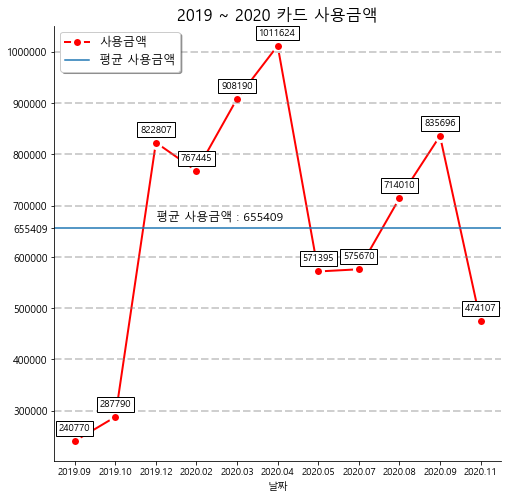

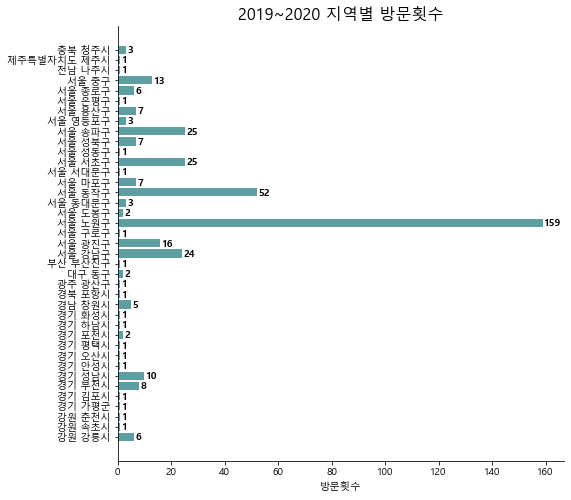

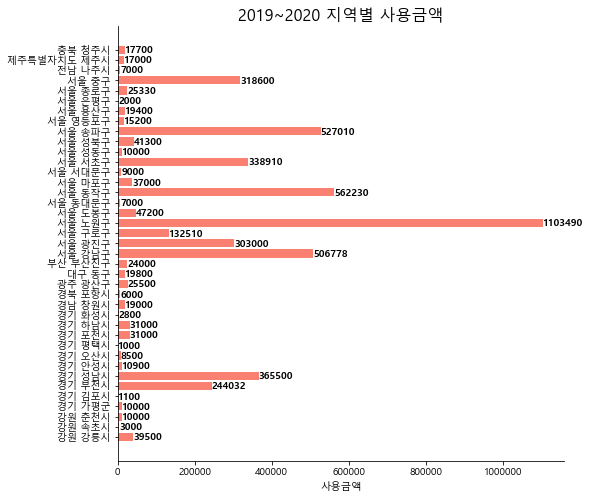

<ipython-input-10-27f061b0ccbc>:289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_1 = plt.figure(figsize=(5,5)) ## Figure 생성 사이즈는 10 by 10


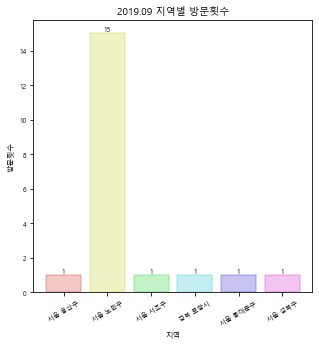

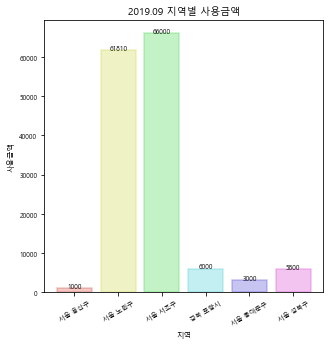

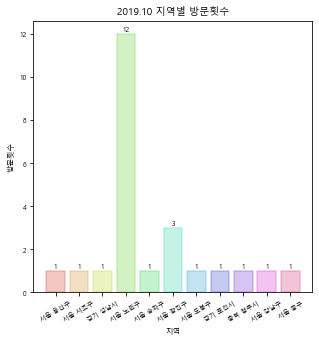

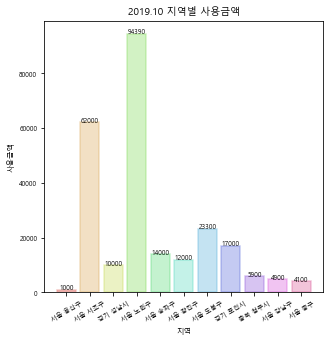

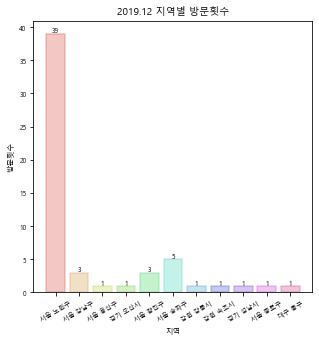

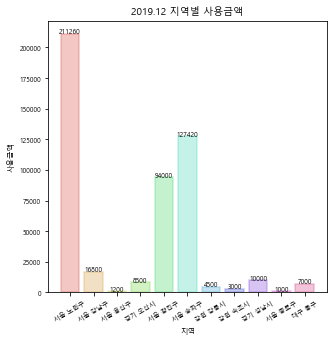

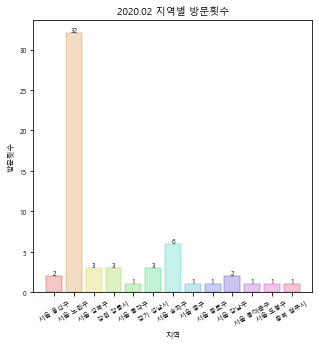

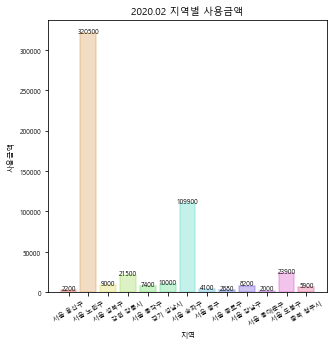

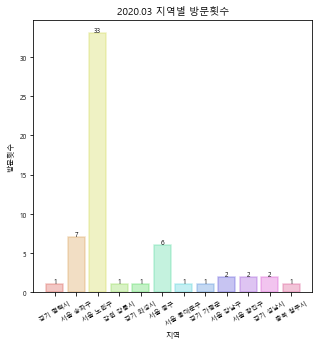

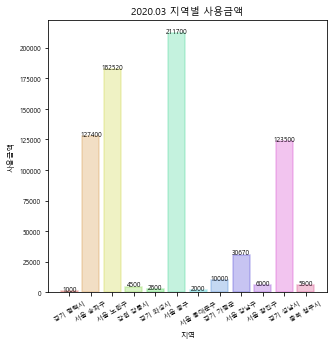

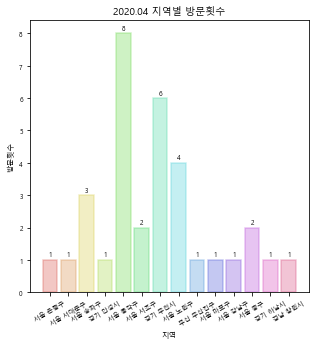

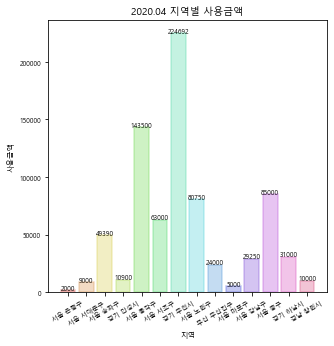

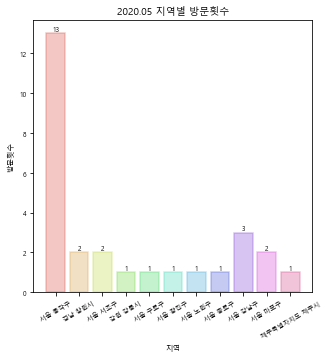

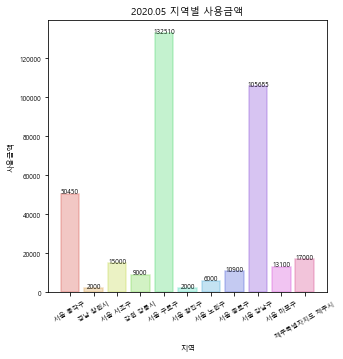

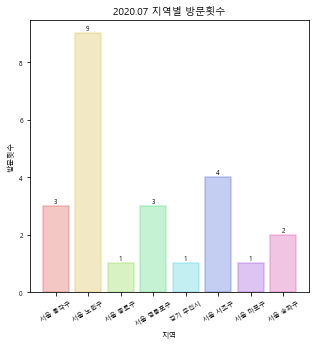

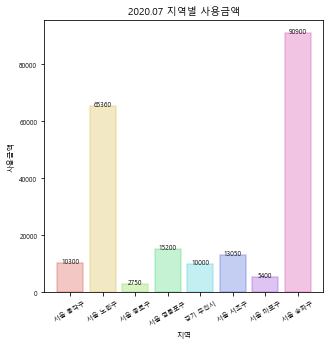

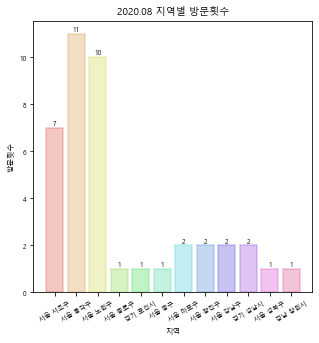

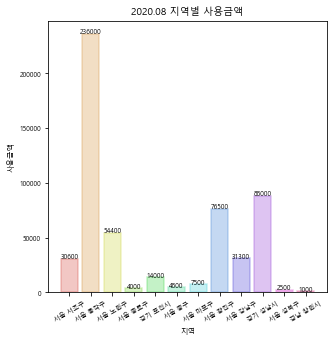

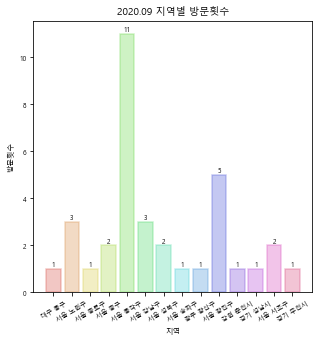

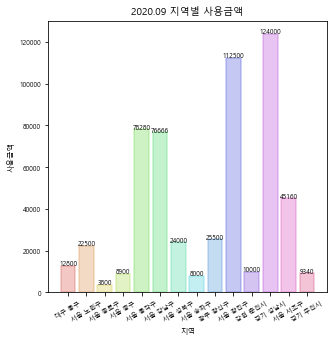

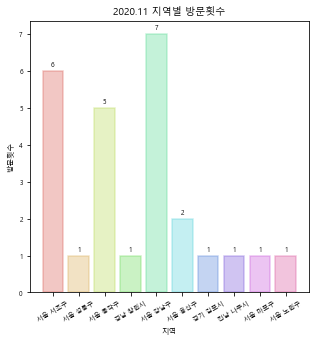

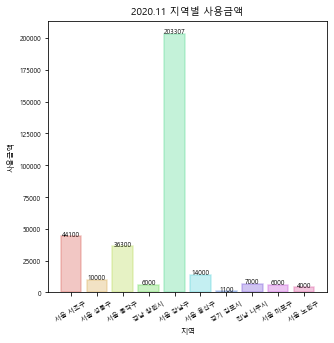

In [10]:
# 체크카드 명세서 자동 불러오기
receipt_data_file = glob.glob(directory + "/shinhancard_*.html") # 지정 폴더안에 있는 모든 파일을 불러내기 위함

# excel_writer로 보낼 data 모음
total_df = []             # 일별 DataFrame 모음
total_df_region = []      # 지역별 DataFrame 모음
List_Sum_Month_tdf = []   # 월별 합계 DataFrame 모음
sheet_nm = []             # Excel Sheet Name 모음
visit_graph = []          # 월기준 지역별 방문횟수 그래프 모음
price_graph = []         # 월기준 지역별 사용금액 그래프 모음

# 위의 'total_df'와 'sheet_nm'에 데이터를 삽입하기 위한 for 구문
for url in receipt_data_file :
    driver = webdriver.Chrome('c:/chromedriver.exe')
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')

    title_tag = soup.select('head > title')
    title = title_tag[0].text
    
    # 암호된 문서일 경우 if 구문으로 들어감
    if title == '' :
        pw = '950730'
        driver.find_element_by_id('password').send_keys(pw)
        driver.find_element_by_xpath('//*[@id="aform"]/span/input').click()
        time.sleep(5)
        html = driver.page_source
        soup = BeautifulSoup(html,'html.parser')
        
    # 암호된 문서가 아닐 경우 아래코드로 바로 들어감
    # 명세서 데이터에서 체크 소계 제거 코드
    tables = soup.select('div#email02 > table.tblList.cardUseList > tbody > tr')
    tables_middleSum = soup.select('div#email02 > table.tblList.cardUseList > tbody > tr.middleSum')
    
    for n in range(len(tables_middleSum)) :
        tables.remove(tables_middleSum[n])
    
    # tables 데이터 string으로 변환하여 분리                      
    seperate_tables = []                        # seperate_tables 초기화
    for n in range(len(tables)) :
        table = str(tables[n].text).split('\n')
        seperate_tables = seperate_tables + table
        
    # seperate_tables에서 '사용날짜' , '사용금액', '사용처' 추출   
    date_list =  [seperate_tables[n] for n in range(1,len(seperate_tables), 12)]
    price_list = [int(seperate_tables[n].replace(',','')) for n in range(4,len(seperate_tables), 12)] 
    store_list = [seperate_tables[n].replace(" ", "") for n in range(3,len(seperate_tables), 12)]

    # seperate_tables에서 추출된 '사용처' 데이터 --> 카카오 지도 API --> '사용처'에 대한 주소 추출
    location_list = []
    def create_url(search_text):
        headers = {'Authorization': 'KakaoAK 3e8ea332f0cdef6293383ac7bf81a6fc'}
        base = "https://dapi.kakao.com/v2/local/search/keyword.json"
        param_query = "?query=" +search_text
        respond = requests.get(base + param_query,headers=headers)
        return respond.json()

    for n in range(len(store_list)) :
        store_name = store_list[n]
        result = create_url(store_name)
        tmp1 = result['documents']
        try :
            tmp2 = tmp1[0]['address_name']
            location_list.append(tmp2)
        except :
            tmp2 = np.nan
            location_list.append(tmp2)
            
    # 추출한 데이터로 DataFrame 변환
    table_data = {'사용날짜':date_list, '사용처':store_list, '사용처주소':location_list,  '사용금액':price_list }
    
    df = pd.DataFrame(table_data, index = range(1,len(date_list)+1,1), columns=['사용날짜', '사용처', '사용처주소', '사용금액'])
    df_sum = pd.DataFrame(df.sum(), columns=['합계'])
    df_total = df.append(df_sum.T)
    df_total.loc['합계', '사용날짜'] = '전체'
    df_total.loc['합계', '사용처'] = '전체'
    df_total.loc['합계', '사용처주소'] = '전체'
    total_df.append(df_total)
    List_Sum_Month_tdf.append(df_sum.T['사용금액'])    # 선그래프를 그리기 위한 합계를 List_Sum_Month_tdf=[]로 보낸다.
        
   # 월별기준 지역별 사용데이터 추출  
    df_dis_nan = df.dropna()

    df_address_list = list(df_dis_nan['사용처주소'])
    df_region_list = [ ' '.join(address.split()[:2]) for address in df_address_list]

    df_price_list = list(df_dis_nan['사용금액'])

    table_data_1 = {'사용지역':df_region_list, '사용금액':df_price_list}
    col_list = ['사용지역', '사용금액']
    df_Dup = pd.DataFrame(table_data_1 , columns = col_list ) # 중복값이 있는 df
    df_NoDup = df_Dup.drop_duplicates(subset = '사용지역')  # 중복값이 없는 df

    index_name_1 = df_Dup['사용지역']  # 중복값이 있는 사용지역 series
    df_Dup_name = df_Dup.rename(index_name_1)
    df_Dup_name = df_Dup_name.drop(['사용지역'], axis = 1)  # 중복값이 있고 사용지역이 index인 df

    index_name_2 = df_NoDup['사용지역']  # 중복값이 없는 사용지역 series
    df_NoDup_name = df_NoDup.rename(index_name_2)
    df_NoDup_name = df_NoDup_name.drop(['사용지역'], axis = 1)  # 중복값이 없고 사용지역이 index인 df

    for nm in list(index_name_2) :
        price_data = df_Dup_name.loc[nm]['사용금액']
        price_sum = price_data.sum()
        df_NoDup_name.loc[nm]['사용금액'] = price_sum

    name_region = df_Dup['사용지역']
    visit_counter = dict(name_region.value_counts())
    counter_list = []
    for k in index_name_2 :
        counter_list.append(visit_counter[k])
    
    df_NoDup_name.insert(0, '방문횟수', counter_list)
    total_df_region.append(df_NoDup_name)
    
    # 엑셀 시트네임 데이터 추출
    tables_date = soup.select('body > div.wrap.check > div.content > div.receiveDate > span.date')
    nm = str(tables_date[0].text)
    sheet_nm.append(nm)
    
    # 팝업창 닫기
    driver.close()

# 엑셀 및 이미지 저장 폴더 만들기
folder = directory
folder_1 = directory + '/image'

if not os.path.exists(folder) :
    os.makedirs(folder)

if not os.path.exists(folder_1) :
    os.makedirs(folder_1)
    
# 월별 사용금액 데이터 시각화(엑셀 첫번째 시트에 들어감)
     
mean_sales = int(np.mean(List_Sum_Month_tdf))

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

args_plot = [sheet_nm, List_Sum_Month_tdf] ## 데이터 인자
config_plot = dict( ## 키워드 인자
    color='red', # 선 색깔
    linestyle='solid', # 선 스타일
    linewidth=2, # 선 두께 
    marker='o', # 마커 모양
    markersize=10, # 마커 사이즈
    markeredgecolor='white', # 마커 테두리 색깔
    markeredgewidth=3, # 마커 테두리 두께
)

line_plot = ax.plot(label='사용금액', *args_plot,**config_plot) ## 선그래프 생성 - 범례라벨 추가
line_plot = line_plot[0]

ax.axhline(mean_sales,label='평균 사용금액') ## 평균값을 y좌표로 하는 수평선 생성
ax.text(2,mean_sales+15000,f'평균 사용금액 : {mean_sales}',fontsize=12) ## 평균 매출 텍스트 출력

bbox = dict( boxstyle='square', facecolor='white')

for coord in list(line_plot.get_xydata()):
    ax.text(coord[0],coord[1]+20000,f'{int(coord[1])}',fontsize=9.6, ha='center', bbox=bbox)

ylim = ax.get_ylim() ## 기존의 y축 범위를 저장

yticks = list(ax.get_yticks()) ## y축 눈금을 가져온다.

for y in yticks:
    ax.axhline(y,linestyle=(0,(5,2)),color='grey',alpha=0.5) ## 눈금선 생성
    
yticks.append(mean_sales)
yticks = sorted(yticks)

ax.set_yticks(yticks) ## 평균이 포함된 y눈금으로 새롭게 세팅한다.
ax.set_ylim(ylim) ## 기존의 y축 범위를 유지
ax.legend(loc='upper left', fontsize=12, shadow=True) ## 범례 생성 - 그림자 효과 추가

plt.gca().get_yaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기
plt.yticks(fontsize=10.4) ## y축 눈금 크기 설정
plt.xticks(rotation=360,fontsize=9.6) ## x축 눈금 회전각도와 크기 설정

plt.ylabel('',rotation=90, fontsize=16, color='black') ## y축 라벨
plt.xlabel('날짜',fontsize=10.4, color='black') ## x축 라벨

plt.title('2019 ~ 2020 카드 사용금액',fontsize=16, color='black') ## 타이틀 설정

graph_file = directory + "/image/mcua.png"

plt.savefig(graph_file, dpi = 200)

########## 시각화를 위한 dataframe #############################

df_region_Dup = pd.DataFrame()        # 중복값이 있는 df_region

for n in range(len(total_df_region)) :
        df_region_Dup = df_region_Dup.append(total_df_region[n])

sorted_df_region_Dup = df_region_Dup.sort_index(ascending=True)  # 오름차순이 적용된 중복값이 있는 df_region

index_region = sorted_df_region_Dup.reset_index().rename(columns={'index': '사용지역'}) # index를 columns로 전환

df_region_NoDup = index_region.drop_duplicates(subset = '사용지역')  # 중복값이 없는 df_region

index_name_3 = df_region_NoDup['사용지역']  
df_region_NoDup_name = df_region_NoDup.rename(index_name_3)
df_region_NoDup_name = df_region_NoDup_name.drop(['사용지역'], axis = 1) # 중복값이 없고 사용지역이 index인 df_region

for nm_1 in list(index_name_3) :
    price_region_data = sorted_df_region_Dup.loc[nm_1]['사용금액']
    price_region_sum = price_region_data.sum()
    df_region_NoDup_name.loc[nm_1]['사용금액'] = price_region_sum        # 지역별 총 사용금액 데이터 삽입
    
    visit_region_data = sorted_df_region_Dup.loc[nm_1]['방문횟수']
    visit_region_sum = visit_region_data.sum()
    df_region_NoDup_name.loc[nm_1]['방문횟수'] = visit_region_sum        # 지역별 총 방문횟수 데이터 삽입

################ 1년간 지역별 총 방문횟수 시각화 ################
## 데이터
total_region_category = index_name_3
total_visit_category = df_region_NoDup_name['방문횟수']
total_price_category = df_region_NoDup_name['사용금액']

## 시각화
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

ytick_label_position = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position, total_region_category) ## y축 눈금 라벨 출력

plt.barh(ytick_label_position, total_visit_category, color = 'cadetblue') ## 바차트 출력

for i, v in enumerate(total_visit_category):
    plt.text(v + .5, i - .3, str(v), color='black', fontweight='bold')
    
plt.title('2019~2020 지역별 방문횟수',fontsize=16) ## 타이틀 출력
plt.xlabel('방문횟수',fontsize=10.4) ## x축 라벨 출력
plt.ylabel('',fontsize=8) ## y축 라벨 출력

graph_file_1 = directory + "/total_visit.png"
plt.savefig(graph_file_1, dpi = 200)
plt.show()

##### 2019~2020 지역별 총 사용금액 ####
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김

ytick_label_position_1 = list(range(len(total_region_category))) ## y축 눈금 라벨이 표시될 x좌표
plt.yticks(ytick_label_position_1, total_region_category) ## y축 눈금 라벨 출력
plt.gca().get_xaxis().get_major_formatter().set_scientific(False) # Y축 지수표현 안하기

plt.barh(ytick_label_position_1, total_price_category, color = 'salmon') ## 바차트 출력

for i, v in enumerate(total_price_category):
    plt.text(v + 1, i - .3, str(v), color='black', fontweight='bold')
    
plt.title('2019~2020 지역별 사용금액',fontsize=16) ## 타이틀 출력
plt.xlabel('사용금액',fontsize=10.4) ## x축 라벨 출력
plt.ylabel('',fontsize=8) ## y축 라벨 출력

graph_file_2 = directory + "/image/total_price.png"
plt.savefig(graph_file_2, dpi = 200)

plt.show()
###################################################

# 월기준 지역 방문횟수 및 사용금액 데이터 시각화(해당 월별 시트에 각각 들어감)

for n in range(len(total_df_region)) :
    c_name = ['방문횟수', '사용금액']
    ta = total_df_region[n]
    sn = sheet_nm[n]
    for k in range(len(c_name)) :
            region_category = ta.index
            visit_category = ta[c_name[k]]
            
            tick_size_1 = 6.5 ## 눈금 폰트 사이즈
            axis_label_size_1 = 7.5 ## x축, y축 폰트 사이즈

            fig_1 = plt.figure(figsize=(5,5)) ## Figure 생성 사이즈는 10 by 10
            ax_1 = fig_1.add_subplot() ## Axes 추가
            colors_1 = sns.color_palette('hls',len(region_category)) ## 색상 지정

            xtick_label_position = list(range(len(region_category))) ## x축 눈금 라벨이 표시될 x좌표

            plt.yticks(fontsize=tick_size_1)
            plt.xticks(xtick_label_position, region_category, rotation = 30, fontsize=tick_size_1) ## x축 눈금 라벨 출력

            bars = plt.bar(xtick_label_position, visit_category, color=colors_1, \
                           edgecolor=colors_1, alpha=0.35, linewidth=1.5) ## 바차트 출력

            for i, b in enumerate(bars):
                ax_1.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                        visit_category[i],ha='center',fontsize=6.5)

            plt.title(f'{sn} 지역별 {c_name[k]}',fontsize=10) ## 타이틀 출력
            plt.xlabel('지역',fontsize=axis_label_size_1) ## x축 라벨 출력
            plt.ylabel(c_name[k],fontsize=axis_label_size_1) ## y축 라벨 출력
            visit_file = directory + f"/{sn}_{c_name[k]}.png"
            plt.savefig(visit_file, dpi = 200)
            
            if c_name[k] == '방문횟수' : 
                visit_graph.append(visit_file)
                
            else :
                price_graph.append(visit_file)
            
# total_df, total_df_region, sheet_nm 데이터를 활용하여 Excel로 저장
    
excel_writer = pd.ExcelWriter(directory + '/CardUseList.xlsx', engine='xlsxwriter')

df_empty = pd.DataFrame()
df_empty.to_excel(excel_writer, index = True, sheet_name = 'Sheet1')
worksheet = excel_writer.sheets['Sheet1']
worksheet.insert_image('A1', graph_file) 
worksheet.insert_image('N1', graph_file_1)
worksheet.insert_image('AA1', graph_file_2)


ToExcel_data =[]

for n in range(len(total_df)) :
    ToAppend_total_df = total_df[n].to_excel(excel_writer, index = True, sheet_name = sheet_nm[n]+' 데이터')
    ToExcel_data.append(ToAppend_total_df)
    
    ToAppend_total_region_df = total_df_region[n].to_excel(excel_writer, index = True, sheet_name = sheet_nm[n]+' 데이터', startcol=6)
    worksheet_1 = excel_writer.sheets[sheet_nm[n]+' 데이터']
    send_worksheet_1 = worksheet_1.insert_image('K1', visit_graph[n])
    send_worksheet_2 = worksheet_1.insert_image('S1', price_graph[n])
    ToExcel_data.append(ToAppend_total_region_df)
    ToExcel_data.append(send_worksheet_1)

excel_writer.save()

In [ ]:
df_address = [] # 위치정보 없는 데이터 삭제한 DF 넣을 리스트
df_address_only = [] # 중복 사용지점 없는 DF 넣을 리스트
data_in_name = [] # 상호명을 기준으로한 DF 넣을 리스트 (중복 포함)
data_in_only_name = [] # 상호명을 기준으로한 DF 넣을 리스트 (중복 미포함)
count_list = [] # 상호에 따른 방문횟수

# df_address : 위치정보 없는 데이터는 삭제한 DF 만들기
df_address = [df.dropna() for df in total_df]

# data_in_only_name : 상호명을 기준으로 한 DF (중복 미 포함) 만들기
df_address_only = [df.drop_duplicates(subset = '사용처') for df in df_address]

# data_in_only_name 
for i in range(len(df_address)):
    
    name_index =  df_address[i]['사용처']
    data_in_name.append(df_address[i].rename(name_index))
    data_in_name[i] = data_in_name[i].drop(['사용처'], axis = 1)

    name_index =  df_address_only[i]['사용처']
    data_in_only_name.append(df_address_only[i].rename(name_index))
    data_in_only_name[i] = data_in_only_name[i].drop(['사용처'], axis = 1)
    
    # 상호별 사용 총액 구하기
    for name in list(name_index):
        tmp_data = data_in_name[i].loc[name]['사용금액']
        
        try:
            price_sum = sum(data_in_name[i].loc[name]['사용금액'])

        except:
            price_sum = data_in_name[i].loc[name]['사용금액']
            
        data_in_only_name[i].loc[name]['사용금액'] = price_sum
            
            
    name_series = df_address[i]['사용처']

    visit_count = dict(name_series.value_counts())

    count_list_tmp = []

    for k in name_index:
        count_list_tmp.append(visit_count[k])

        
    count_list.append(count_list_tmp)
    
    # 사용횟수 열 추가하기

    data_in_only_name[i].insert(3, '방문횟수', count_list[i])

import requests

coordinates_x = []
coordinates_y = []

# 주소로 위치의 위도 경도 값 받는 메소드
def getLatLng(address):
    result = ""
 
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
    rest_api_key = '289858dc68417f30677b064987b71bab'
    header = {'Authorization': 'KakaoAK ' + rest_api_key}
 
    r = requests.get(url, headers=header)
 
    if r.status_code == 200:
        try:
            result_address = r.json()["documents"][0]["address"]
            result = result_address["y"], result_address["x"]
        except:
            result = False
    else:
        result = "ERROR[" + str(r.status_code) + "]"
    
    return result

# 월별 사용내역 지도 생성
for i in range(len(data_in_only_name)):

    # 지도 생성에 사용할 데이터
    date = list(data_in_only_name[i]['사용날짜'][:-1])
    store_name = list(data_in_only_name[i].index[:-1])
    address = list(data_in_only_name[i]['사용처주소'][:-1])
    price = list(data_in_only_name[i]['사용금액'][:-1])
    count = list(data_in_only_name[i]['방문횟수'][:-1])

    coordinates_x = []
    coordinates_y = []
    
    for j in address:
        
        coor = getLatLng(j)
        

        if coor != False:
            coordinates_x.append(coor[0])
            coordinates_y.append(coor[1])
        else:
            coordinates_x.append(False)
            coordinates_y.append(False)

    html = '<div id="map" style="width:100%;height:100%;"></div>'
    html = html + '<script type="text/javascript" src="//dapi.kakao.com/v2/maps/sdk.js?appkey=562beaefa8f3396ba21741328654bece"></script>\n'
    html = html + '<script>\n'
    html = html + "var mapContainer = document.getElementById('map'), \n"
    html = html + '    mapOption = { \n'

    html = html + '        center: new kakao.maps.LatLng(37.566826, 126.9786567), \n'
    html = html + '        level: 7 \n'
    html = html + '    };'

    html = html + """
    var map = new kakao.maps.Map(mapContainer, mapOption); // 지도를 생성합니다

    // 마커를 표시할 위치와 title 객체 배열입니다 

    var positions = []
    """
    for k in range(len(store_name)):
        if coordinates_x[k] == False:
            continue
        html = html + "positions.push({ title: " + f"'{store_name[k]}', price: '{price[k]}', count: '{count[k]}'," + f" latlng: new kakao.maps.LatLng({coordinates_x[k]}, {coordinates_y[k]})" + "})\n"

    html = html + """
    // 마커 이미지의 이미지 주소입니다
    var imageSrc = "https://t1.daumcdn.net/localimg/localimages/07/mapapidoc/markerStar.png"; 

    for (var i = 0; i < positions.length; i ++) {

        // 마커 이미지의 이미지 크기 입니다
        //var imageSize = new kakao.maps.Size(24, 35); 

        // 마커 이미지를 생성합니다    
        //var markerImage = new kakao.maps.MarkerImage(imageSrc, imageSize); 

        // 마커를 생성합니다
        var marker = new kakao.maps.Marker({
            map: map, // 마커를 표시할 지도
            position: positions[i].latlng, // 마커를 표시할 위치
        //    title : positions[i].title, // 마커의 타이틀, 마커에 마우스를 올리면 타이틀이 표시됩니다
        //    image : markerImage // 마커 이미지 
        });

        var infowindow = new kakao.maps.InfoWindow({
            //position : positions[i].latlng, 
            content : '<div style="width:100%;height:100%;font-size:11px">상호명 : ' + positions[i].title + '<br>방문횟수 : ' + positions[i].count + '<br>사용금액 : ' + positions[i].price +  '</div>'
        });
        
        
        kakao.maps.event.addListener(marker, 'mouseover', makeOverListener(map, marker, infowindow));
        kakao.maps.event.addListener(marker, 'mouseout', makeOutListener(infowindow));
        
        //marker.setMap(map);


        //infowindow.open(map, marker); 
        
        

    }
    
    function makeOverListener(map, marker, infowindow) {
        return function() {
            infowindow.open(map, marker);
        };
    }

    // 인포윈도우를 닫는 클로저를 만드는 함수입니다 
    function makeOutListener(infowindow) {
        return function() {
            infowindow.close();
        };
    }
    
    </script>"""

    map_file = open('map_' + sheet_nm[i] + '.html', 'w')
    map_file.write(html)
    map_file.close()

    print(html)

<div id="map" style="width:100%;height:100%;"></div><script type="text/javascript" src="//dapi.kakao.com/v2/maps/sdk.js?appkey=562beaefa8f3396ba21741328654bece"></script>
<script>
var mapContainer = document.getElementById('map'), 
    mapOption = { 
        center: new kakao.maps.LatLng(37.566826, 126.9786567), 
        level: 7 
    };
    var map = new kakao.maps.Map(mapContainer, mapOption); // 지도를 생성합니다

    // 마커를 표시할 위치와 title 객체 배열입니다 

    var positions = []
    positions.push({ title: '자판기', price: '1000', count: '1', latlng: new kakao.maps.LatLng(37.5383303723553, 126.987097452984)})
positions.push({ title: '다이소(공릉점)', price: '5000', count: '1', latlng: new kakao.maps.LatLng(37.6264557243819, 127.074491271089)})
positions.push({ title: '세븐일레븐노원공릉그린점', price: '22200', count: '5', latlng: new kakao.maps.LatLng(37.6245976355883, 127.0783613752)})
positions.push({ title: '이마트24노원공릉점', price: '4800', count: '2', latlng: new kakao.maps.LatLng(37.6249345631284, 127.077743114464)})


<div id="map" style="width:100%;height:100%;"></div><script type="text/javascript" src="//dapi.kakao.com/v2/maps/sdk.js?appkey=562beaefa8f3396ba21741328654bece"></script>
<script>
var mapContainer = document.getElementById('map'), 
    mapOption = { 
        center: new kakao.maps.LatLng(37.566826, 126.9786567), 
        level: 7 
    };
    var map = new kakao.maps.Map(mapContainer, mapOption); // 지도를 생성합니다

    // 마커를 표시할 위치와 title 객체 배열입니다 

    var positions = []
    positions.push({ title: '이마트24노원공릉점', price: '32200', count: '8', latlng: new kakao.maps.LatLng(37.6249345631284, 127.077743114464)})
positions.push({ title: '맥도날드', price: '16800', count: '3', latlng: new kakao.maps.LatLng(37.4987083234515, 127.028660034939)})
positions.push({ title: '다이소(공릉점)', price: '9020', count: '1', latlng: new kakao.maps.LatLng(37.6264557243819, 127.074491271089)})
positions.push({ title: '자판기', price: '1200', count: '1', latlng: new kakao.maps.LatLng(37.5383303723553, 126.987097452984)})
posit

<div id="map" style="width:100%;height:100%;"></div><script type="text/javascript" src="//dapi.kakao.com/v2/maps/sdk.js?appkey=562beaefa8f3396ba21741328654bece"></script>
<script>
var mapContainer = document.getElementById('map'), 
    mapOption = { 
        center: new kakao.maps.LatLng(37.566826, 126.9786567), 
        level: 7 
    };
    var map = new kakao.maps.Map(mapContainer, mapOption); // 지도를 생성합니다

    // 마커를 표시할 위치와 title 객체 배열입니다 

    var positions = []
    positions.push({ title: '주)우아한형제들', price: '118900', count: '6', latlng: new kakao.maps.LatLng(37.5169302452841, 127.112781230361)})
positions.push({ title: '세븐일레븐노원공릉그린점', price: '43100', count: '11', latlng: new kakao.maps.LatLng(37.6245976355883, 127.0783613752)})
positions.push({ title: '밥은', price: '4500', count: '1', latlng: new kakao.maps.LatLng(37.7870312180427, 128.907981003376)})
positions.push({ title: '다이소(공릉점)', price: '3500', count: '2', latlng: new kakao.maps.LatLng(37.6264557243819, 127.074491271089)})


<div id="map" style="width:100%;height:100%;"></div><script type="text/javascript" src="//dapi.kakao.com/v2/maps/sdk.js?appkey=562beaefa8f3396ba21741328654bece"></script>
<script>
var mapContainer = document.getElementById('map'), 
    mapOption = { 
        center: new kakao.maps.LatLng(37.566826, 126.9786567), 
        level: 7 
    };
    var map = new kakao.maps.Map(mapContainer, mapOption); // 지도를 생성합니다

    // 마커를 표시할 위치와 title 객체 배열입니다 

    var positions = []
    positions.push({ title: '씨유이수나누리점', price: '4500', count: '1', latlng: new kakao.maps.LatLng(37.4876448251511, 126.981013458035)})
positions.push({ title: '왕창할인마트', price: '39350', count: '10', latlng: new kakao.maps.LatLng(37.4883946353717, 126.978344313895)})
positions.push({ title: '주식회사아성다이소', price: '2000', count: '2', latlng: new kakao.maps.LatLng(35.2212533386035, 128.681235260685)})
positions.push({ title: '방배세명약국', price: '6000', count: '1', latlng: new kakao.maps.LatLng(37.486747765286, 126.982666423995)})
po

<div id="map" style="width:100%;height:100%;"></div><script type="text/javascript" src="//dapi.kakao.com/v2/maps/sdk.js?appkey=562beaefa8f3396ba21741328654bece"></script>
<script>
var mapContainer = document.getElementById('map'), 
    mapOption = { 
        center: new kakao.maps.LatLng(37.566826, 126.9786567), 
        level: 7 
    };
    var map = new kakao.maps.Map(mapContainer, mapOption); // 지도를 생성합니다

    // 마커를 표시할 위치와 title 객체 배열입니다 

    var positions = []
    positions.push({ title: '바나프레소삼성타운점', price: '6000', count: '2', latlng: new kakao.maps.LatLng(37.4954076853265, 127.027826145715)})
positions.push({ title: '알파카피센터', price: '11800', count: '2', latlng: new kakao.maps.LatLng(37.4967852776426, 127.02764221559)})
positions.push({ title: '알파강남본점', price: '1800', count: '1', latlng: new kakao.maps.LatLng(37.4967852776426, 127.02764221559)})
positions.push({ title: '씨유강남승리점', price: '5000', count: '1', latlng: new kakao.maps.LatLng(37.4951230251758, 127.027962078063)})
posi